In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import erf
from scipy.integrate import quad
from scipy.fft import dst
import networkx as nx
import math
import torch

from utils import *
from intersection_graph import *

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('text', usetex=False)

In [38]:
def optimise_vanishing_set(phi, dphi, n=10, seed=0, steps=2000, lr=0.1, tol=1e-10):
    """
    Projected gradient descent on the unit sphere S^{n-1} to approximate a
    vanishing direction x (i.e. where h(x) = <x, phi(x)> ≈ 0).

    We minimise J(x) = 0.5 * h(x)^2 subject to ||x|| = 1.
    The cone structure of Z_f (scale-invariant) means it suffices to search
    for directions on the sphere instead of all R^n.
    """

    rng = np.random.default_rng(seed)
    x = rng.normal(size=n)
    x /= np.linalg.norm(x)   # start on unit sphere S^{n-1}

    # h(x) = <x, f(x)> = Σ x_i φ(x_i).  Vanishes exactly on Z_f.
    def h(x): return float(np.dot(x, phi(x)))

    # ∇h(x) = φ(x) + φ'(x) * x (elementwise).  Chain rule for x_i φ(x_i).
    def grad_h(x): return phi(x) + dphi(x) * x

    # Project v onto tangent space of sphere at x: (I - xx^T)v.
    def proj_tangent(x, v): return v - x * np.dot(x, v)

    # Retraction: step along tangent then renormalise back to S^{n-1}.
    def step_on_sphere(x, g, eta):
        y = x - eta * g
        return y / np.linalg.norm(y)

    hx_hist = []  # track |h(x)| values over iterations

    for k in range(steps):
        hx = h(x)
        hx_hist.append(abs(hx))
        if abs(hx) <= tol:          # convergence if |h(x)| small enough
            return x, hx, hx_hist

        g_euc = grad_h(x)           # Euclidean gradient of h
        # Riemannian gradient of J = 0.5 h^2: grad_S J = h * (proj tangent ∇h)
        g_sph = hx * proj_tangent(x, g_euc)
        x = step_on_sphere(x, g_sph, lr)

    return x, h(x), hx_hist


# ---------------- metrics for activations ----------------
def activation_metrics(phi, dphi, n=10, restarts=20, eps=1e-3):
    """
    Estimate vanishing-set behaviour by repeated optimisation runs.
    Reports:
      - min_value: smallest |h(x)| found,
      - median_value: median |h(x)| across runs,
      - near_zero_prob: frequency of runs with |h(x)| < eps.
    Useful for comparing activations by how often they admit (approx.) zeros.
    """
    near_zero_count = 0
    min_vals = []
    for r in range(restarts):
        x, hx, _ = optimise_vanishing_set(phi, dphi, n=n, seed=r)
        min_vals.append(abs(hx))
        if abs(hx) < eps:
            near_zero_count += 1
    return {
        "min_value": min(min_vals),
        "median_value": np.median(min_vals),
        "near_zero_prob": near_zero_count / restarts
    }


# ---------------- visualisation (2D only) ----------------
def plot_vanishing_set(phi, dphi, name="activation", n_points=400, eps=1e-2, seed=0):
    """
    Visualise Z_f ∩ S^1 in 2D:
      - sample points on unit circle and mark where |h(x)| < eps,
      - plot one optimisation trajectory on the circle,
      - show convergence of |h(x)| over iterations.
    """

    theta = np.linspace(0, 2*np.pi, n_points)
    circle = np.c_[np.cos(theta), np.sin(theta)]

    # Evaluate h(x) along circle; near-zero points approximate vanishing set.
    hvals = np.array([np.dot(p, phi(p)) for p in circle])
    zeros = circle[np.abs(hvals) < eps]

    # Run optimisation once in 2D for a trajectory
    x, hx, hx_hist = optimise_vanishing_set(phi, dphi, n=2, seed=seed, steps=500)

    # Explicitly recompute trajectory points to plot optimisation path
    rng = np.random.default_rng(seed)
    xt = rng.normal(size=2); xt /= np.linalg.norm(xt)
    tr = [xt]
    for _ in range(200):
        hx = float(np.dot(xt, phi(xt)))
        g_euc = phi(xt) + dphi(xt) * xt
        g_sph = hx * (g_euc - xt * np.dot(xt, g_euc))
        xt = (xt - 0.2 * g_sph) / np.linalg.norm(xt)
        tr.append(xt)
    traj = np.array(tr)

    # Plot geometry (circle, vanishing set points, trajectory)
    fig, axs = plt.subplots(1,2,figsize=(12,5))

    axs[0].plot(circle[:,0], circle[:,1], 'k--', alpha=0.3)  # unit circle
    axs[0].scatter(zeros[:,0], zeros[:,1], c='red', label="~vanishing set")
    axs[0].plot(traj[:,0], traj[:,1], 'b.-', label="trajectory")
    axs[0].scatter([traj[0,0]],[traj[0,1]],c='green',label="start")
    axs[0].set_aspect("equal")
    axs[0].set_title(f"2D geometry for {name}")
    axs[0].legend()

    # Plot convergence of |h(x)|
    axs[1].semilogy(hx_hist)
    axs[1].set_title("|h(x)| over iterations")
    axs[1].set_xlabel("iteration")
    axs[1].set_ylabel("|h|")
    plt.show()


x* on sphere: [ 0.04110816 -0.9991547 ]
<x*, f(x*)> = 0.001689880691330605


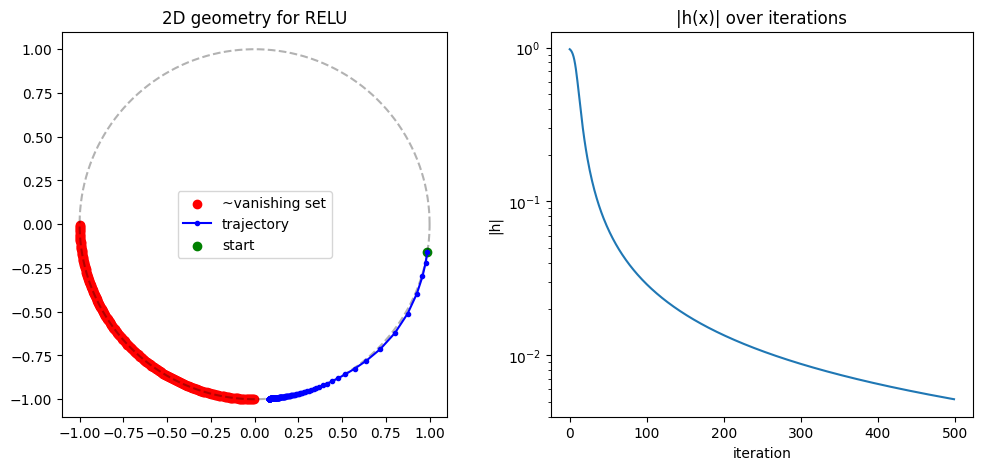

In [74]:
seed = np.random.randint(1000000)

phi, dphi = RELU, dRELU
x_star, h_val, h_hist = optimise_vanishing_set(phi=phi, dphi=dphi, n=2, seed=seed, steps=3000, lr=0.05, tol=1e-8)
print("x* on sphere:", x_star)
print("<x*, f(x*)> =", h_val)

plot_vanishing_set(phi=phi, dphi=dphi, name=phi.__name__, n_points=1000, eps=1e-12, seed=seed)